In [53]:
# GLOBAL VARIABLES
GIT_URL = "https://github.com/chaimaeouardani/img_classification"
IMG_BASE = "img_classification/"
CLASSES = ["hiver", "printemps", "ete", "automne"]


In [54]:
!git clone $GIT_URL
!git -C img_classification pull 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 train/automne/image_low_369.jpg     | Bin 0 -> 137945 bytes
 train/automne/image_low_37.jpg      | Bin 0 -> 349378 bytes
 train/automne/image_low_370.jpg     | Bin 0 -> 279038 bytes
 train/automne/image_low_371.jpg     | Bin 0 -> 328038 bytes
 train/automne/image_low_372.jpg     | Bin 0 -> 288711 bytes
 train/automne/image_low_374.jpg     | Bin 0 -> 223487 bytes
 train/automne/image_low_375.jpg     | Bin 0 -> 458101 bytes
 train/automne/image_low_376.jpg     | Bin 0 -> 159845 bytes
 train/automne/image_low_377.jpg     | Bin 0 -> 28023 bytes
 train/automne/image_low_378.jpg     | Bin 0 -> 582013 bytes
 train/automne/image_low_379.jpg     | Bin 0 -> 77230 bytes
 train/automne/image_low_38.jpg      | Bin 0 -> 329151 bytes
 train/automne/image_low_380.jpg     | Bin 0 -> 147482 bytes
 train/automne/image_low_381.jpg     | Bin 0 -> 127843 bytes
 train/automne/image_low_384.jpg     | Bin 0 -> 188025 bytes
 train/au

In [55]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

def load_data(data_path, classes, dataset, image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    print(f"Found {num_images}.")

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        print(f"Processing class \"{classes[idx_class]}\":")
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            print(f"\r\033[K- Processing image {idx_img+1}/{len(dirs)}", end = "")
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1

        print(f"\r\033[KFinished processing {classes[idx_class]}")

    return x, y

In [56]:
labels = CLASSES

print("--------loading train data-------")
x_train, y_train = load_data(IMG_BASE, labels, dataset='train', image_size=64)
print(x_train.shape, y_train.shape)
print("--------loading validation data-------")
x_val, y_val = load_data(IMG_BASE, labels, dataset='validation', image_size=64)
print(x_val.shape, y_val.shape)
print("--------loading test data-------")
x_test, y_test = load_data(IMG_BASE, labels, dataset='test', image_size=64)
print(x_test.shape, y_test.shape)

--------loading train data-------
Found 4703.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(4703, 64, 64, 3) (4703, 1)
--------loading validation data-------
Found 1996.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(1996, 64, 64, 3) (1996, 1)
--------loading test data-------
Found 1836.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(1836, 64, 64, 3) (1836, 1)


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

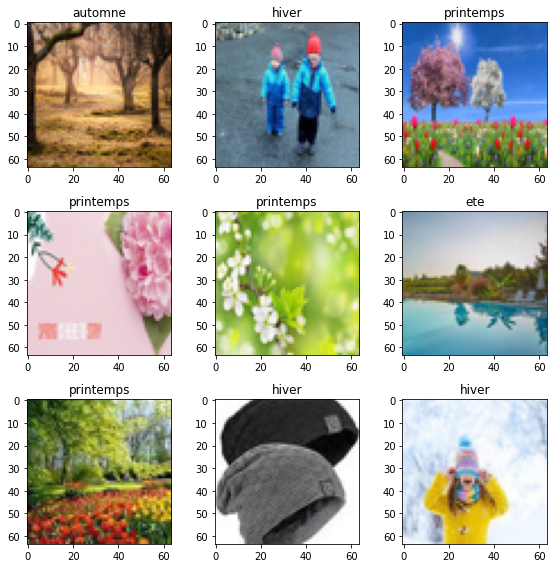

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
shuffle_indices = np.random.permutation(y_train.shape[0])
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

Début d'entrainement des données

In [58]:
import numpy as np
import math
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn import datasets

from tensorflow.keras.layers import Conv2D, MaxPooling2D , Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers , Input

In [59]:
import keras.backend as K

def custom_mse(y_true, y_pred):
    # Changement de dimension : Bx3x14 -> Bx14x3
    y_true = K.permute_dimensions(y_true, (0, 2, 1))
    # Changement de dimension : Bx14x3 -> (B*14)x3
    y_true = K.reshape(y_true, shape=(-1, 3))
  
    # Changement de dimension : Bx2x14 -> Bx14x2
    y_pred = K.permute_dimensions(y_pred, (0, 2, 1))
    # Changement de dimension : Bx14x2 -> (B*14)x2
    y_pred = K.reshape(y_pred, shape=(-1, 2))
    
    # Détermination de l'indices des joints visibles
    visible = K.greater_equal(y_true[:, 2], 1)  
    indices = K.arange(0, K.shape(y_true)[0])
    indices_visible = indices[visible]
    
    # Sélection des vérité-terrains et prédictions des joints visibles
    y_true_visible = K.gather(y_true[:,0:2], indices_visible)
    y_pred_visible = K.gather(y_pred, indices_visible)
    
    # Calcul de la MSE
    return K.mean(K.square(y_pred_visible[:,0] - y_true_visible[:,0]) + K.square(y_pred_visible[:,1] - y_true_visible[:,1]))

def custom_mae(y_true, y_pred):
    # ... A COMPLETER
    # Changement de dimension : Bx3x14 -> Bx14x3
    y_true = K.permute_dimensions(y_true, (0, 2, 1))
    # Changement de dimension : Bx14x3 -> (B*14)x3
    y_true = K.reshape(y_true, shape=(-1, 3))
  
    # Changement de dimension : Bx2x14 -> Bx14x2
    y_pred = K.permute_dimensions(y_pred, (0, 2, 1))
    # Changement de dimension : Bx14x2 -> (B*14)x2
    y_pred = K.reshape(y_pred, shape=(-1, 2))
    
    # Détermination de l'indices des joints visibles
    visible = K.greater_equal(y_true[:, 2], 1)  
    indices = K.arange(0, K.shape(y_true)[0])
    indices_visible = indices[visible]
    
    # Sélection des vérité-terrains et prédictions des joints visibles
    y_true_visible = K.gather(y_true[:,0:2], indices_visible)
    y_pred_visible = K.gather(y_pred, indices_visible)
    
    # Calcul de la MSE
    return K.mean(K.abs(y_pred_visible[:,0] - y_true_visible[:,0]) + K.abs(y_pred_visible[:,1] - y_true_visible[:,1]))

In [60]:
def define_model():
    model = Sequential()
    #model.add(Input(shape=(64, 64, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, kernel_size= (3,3), padding='same', strides=(1,1), activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(96, kernel_size= (3,3),  padding='same', strides=(1,1), activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(128, kernel_size= (3,3),  padding='same', strides=(1,1), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.build()

    #model.add(tensorflow.keras.layers.Reshape((2,4)))
    model.summary()
    
	# compile model
    opt = optimizers.Adam(learning_rate=3e-4)
    #opt = 	opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy' , metrics = ['accuracy'])
    
    #history = model.fit(x_train, y_train, epochs=10, batch_size=20)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)
    
    return model , history

In [61]:
def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 96)        55392     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 96)        

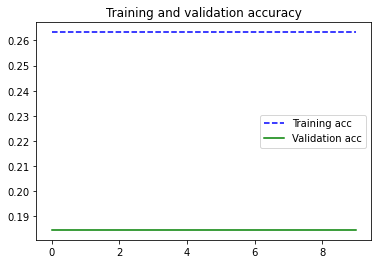

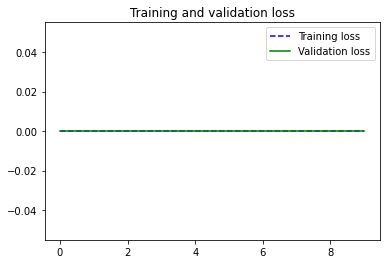

In [62]:
#evaluation of the model

model , history = define_model()
print(history.history.keys())
plot_training_analysis(history)
